# Simulating Neanderthal admixture in European and Asian populations with msprime

*Moisès Coll Macià*

moicoll@birc.au.dk

<a name="casa"></a>

## Contents

1. [ Introduction ](#intro)
2. [ Packages ](#pack)
3. [ Parameters ](#paramameters)
4. [ Samples ](#samples_to_take)
5. [ Simulation with msprime ](#simulations_msprime)
6. [ Output VCF file like ](#output_VCFlike)

    
<a name="intro"></a>

## 1. Introduction 

In this Jupyther notebook I use msprime to simulate African, West Eurasian, East Asian and Archaic populations using msprime. I simulated 5 archaic populations: 3 Neanderthals (Vindija, Altai and intN) and 2 Denisovan populations (Denisova and intD). Both intN and intD correspond to the archaic populations that admixed with modern humans. In fact, I simulate the major admixture from Neanderthals to non-Africans (2%). The other archaic populations represent the genomes of the high coverage archaic samples (**D**enisova, **A**ltai Neanderthal and **V**indija Nenanderthal; **DAV**). The demographic model with split times, effective population sizes, admixture times and proportions for these populations is shown in [ Figure 1 ](#Figure1_demo). 

<a name="Figure1_demo"></a>

<img src="dem_sim.png" alt="Drawing" style="width: 1000px;"/>

**Figure 1.** Graphical representation of the demographic scenario simulated with msprime. Numbers on the left vertical margin indicate the time (in years) of each event. Names of each population simulated are shown on the bottom horizontal margin of the figure. Numbers below those names show the number of haplotipic samples to be taken from each population. The blue rectangles represent the phylogenetic relation among samples and their width is scaled according to effective population size or $N_e$ (also indicated as numbers for each branch). The admixture event from Neanderthals to non-Africans is shown as an arrow in red. Other arrows in gray show that they are coded in the simulation but that they have no effect.


[<img src="arrow.png" width="100" style="float: left;">](#casa) &nbsp;

&nbsp;

<a name="pack"></a>
## 2. Packages

For python

In [1]:
import msprime as msp
import time
import numpy as np
import sys
import math
import os
from Bio import SeqIO
import gzip
from collections import defaultdict
import timeit
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

R[write to console]: During startup - 
R[write to console]: Warning message:

R[write to console]: Setting LC_CTYPE failed, using "C" 

/home/moicoll/miniconda2/envs/GenerationTime_simulations/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


For R

In [2]:
%%R

library(ggplot2)
library(tidyverse)

R[write to console]: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --

R[write to console]: v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0
v purrr   0.3.4     

R[write to console]: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()




[ <img src="arrow.png" width="100" style="float: left;"> ](#casa) &nbsp;

&nbsp;


<a name="paramameters"></a>
## 3. Parameters

In this section I declare the variables with their corresponding value shown in [ Figure 1 ](#Figure1_demo). 

In [4]:
# Generation time, mutation rate and chromosome
gen_time = 29.0    
mut_rate =  1.25e-8 
chrom    = 22

# Admixture ratio and proportions
bac_rate         = 0    
P_Asia_Nean      = 0
P_Euro_Asia_Nean = 0.02

# Population sizes (malaspinas 2016)
## Current population sizes
N_Afri = 27122 
N_Euro =  5000 
N_Asia =  5000 
N_Nint =  1000 
N_Nvin =  1000
N_Nalt =  1000
N_Deni =  2000
N_Dint =  2000

## Ancestral population sizes
N_Euro_Asia           = 5000 
N_Euro_Asia_Afri      = 7000 
N_Nint_Nvin           = 1000
N_Nint_Nvin_Nalt      = 2000
N_Deni_Dint           = 2000
N_Arch                = 5000
N_Euro_Asia_Afri_Arch = 7000 

## Bottleneck population sizes
N_B_Euro_Asia_1 =  250 
N_B_Euro_Asia_2 = 1305 

# Times
## Split Times
T_S_Euro_Asia_Afri_Arch = 580000 / gen_time 
T_S_Arch                = 420000 / gen_time
T_S_Deni_Dint           = 350000 / gen_time
T_S_Nint_Nvin_Nalt      = 130000 / gen_time
T_S_Nint_Nvin           =  90000 / gen_time
T_S_Euro_Asia_Afri      =  62041 / gen_time 
T_S_Euro_Asia           =  41997 / gen_time 

## Bottleneck Times
T_B_Euro_Asia = 57100 / gen_time 


## Bottleneck duration
T_B = 100 

## Admixture Times
T_A_Euro_Asia_Nean = 54000 / gen_time 
T_A_Asia_Nean      = 38000 / gen_time 
T_A_Afri_Euro      =     0 / gen_time 


# Define population_configurations paramter. The commented numbers are the population id in the simulations. 
population_configurations = [
    msp.PopulationConfiguration(initial_size = N_Afri), #0 ---|-----------|------
    msp.PopulationConfiguration(initial_size = N_Euro), #1 -|-|           |
    msp.PopulationConfiguration(initial_size = N_Asia), #2 -|             |
    msp.PopulationConfiguration(initial_size = N_Nint), #3 -----|-|----|--|
    msp.PopulationConfiguration(initial_size = N_Nvin), #4 -----| |    |
    msp.PopulationConfiguration(initial_size = N_Nalt), #5 -------|    |
    msp.PopulationConfiguration(initial_size = N_Deni), #6 ---------|--|
    msp.PopulationConfiguration(initial_size = N_Dint)  #7 ---------|
]

demographic_events = [
    # End Europe to Africa backflow
    msp.MigrationRateChange(time = 0, rate = bac_rate, matrix_index = (0, 1)),
    # Start Europe to Africa backflow
    msp.MigrationRateChange(time= T_A_Afri_Euro, rate= 0, matrix_index=(0, 1)),
    # Gene flow from Neanderthals to Asia
    msp.MassMigration(time = T_A_Asia_Nean, source = 2, destination = 3, proportion = P_Asia_Nean),
    # Europeans and Asians divergence
    msp.MassMigration(time = T_S_Euro_Asia, source = 2, destination = 1, proportion = 1.0),
    # Eurasians population size
    msp.PopulationParametersChange(time = T_S_Euro_Asia, initial_size = N_Euro_Asia, growth_rate = 0, population_id = 1),
    # Neanderthal admixture into Eurasians
    msp.MassMigration(time = T_A_Euro_Asia_Nean, source = 1, destination = 3, proportion = P_Euro_Asia_Nean),
    # Eurasians bottleneck
    msp.PopulationParametersChange(time = T_B_Euro_Asia - T_B, initial_size = N_B_Euro_Asia_2, growth_rate = 0, population_id = 1),
    # Eurasia population size
    msp.PopulationParametersChange(time = T_B_Euro_Asia, initial_size = N_Euro_Asia, growth_rate = 0, population_id = 1),
    # Out of Africa bottleneck
    msp.PopulationParametersChange(time = T_S_Euro_Asia_Afri - T_B, initial_size = N_B_Euro_Asia_1, growth_rate = 0, population_id = 1),
    # Eurasians diverge from Africans
    msp.MassMigration(time = T_S_Euro_Asia_Afri, source = 1, destination = 0, proportion = 1.0),
    msp.PopulationParametersChange(time = T_S_Euro_Asia_Afri, initial_size = N_Euro_Asia_Afri, growth_rate = 0, population_id = 0), # a bit different (Laurits adds 0.0001 to time)
    # Introgressing Neanderthal and Vindija Neanderthal split
    msp.MassMigration(time = T_S_Nint_Nvin, source = 4, destination = 3, proportion = 1.0),
    msp.PopulationParametersChange(time = T_S_Nint_Nvin, initial_size = N_Nint_Nvin, growth_rate = 0, population_id = 3),
    # Introgressing Neanderthal, Vindija Neanderthal and Altai Neanderthal split
    msp.MassMigration(time = T_S_Nint_Nvin_Nalt, source = 5, destination = 3, proportion = 1.0),
    msp.PopulationParametersChange(time = T_S_Nint_Nvin_Nalt, initial_size = N_Nint_Nvin_Nalt, growth_rate = 0, population_id = 3),
    # Introgressing Denisova and sequenced Denisova split
    msp.MassMigration(time = T_S_Deni_Dint, source = 7, destination = 6, proportion = 1.0),
    msp.PopulationParametersChange(time = T_S_Deni_Dint, initial_size = N_Deni_Dint, growth_rate = 0, population_id = 6),
    # Archaics split
    msp.MassMigration(time = T_S_Arch, source = 6, destination = 3, proportion = 1.0),
    msp.PopulationParametersChange(time = T_S_Arch, initial_size = N_Arch, growth_rate = 0, population_id = 3),
    # Neanderthals and modern humans divergence
    msp.MassMigration(time = T_S_Euro_Asia_Afri_Arch, source = 3, destination = 0, proportion = 1.0),
    # Ancestral population size of Neanderthals and modern humans
    msp.PopulationParametersChange(time = T_S_Euro_Asia_Afri_Arch, initial_size = N_Euro_Asia_Afri_Arch, growth_rate = 0, population_id = 0), 
]


[<img src="arrow.png" width="100" style="float: left;">](#casa) &nbsp;

&nbsp;


<a name="samples_to_take"></a>
## 4. Samples

Here, I define the samples that I'm going to get from the different populations and the time that these samples are going to be retrieved (backwards in time). The sample details are summarized in [ Table 1 ](#Table1).

<a name="Table1"></a>

population   | nº haplotipic samples | sampling time (years)
-------------|-----------------------|----------------------
Africa       | 1000                  |      0
West Eurasia |  100                  |      0
East Asia    |  100                  |      0
Vindija      |    2                  |  60000
Altai        |    2                  | 120000
Denisova     |    2                  |  80000

**Table 1.** Samples to be extracted from the demographic simulation.


In [19]:
sample_index = defaultdict(lambda : defaultdict(lambda : None))

i2p = {0 : "African",
       1 : "European",
       2 : "Asian",
       4 : "Vindija",
       5 : "Altai",
       6 : "Denisova"}

samples = []
col     = 0
col_out = 2

pop_to_sample = [   0,                               1,                               2,                  4,                   5,                 6]
num_to_sample = [1000,                             100,                             100,                  2,                   2,                 2]
tim_to_sample = [ [0], [x for x in range(0, 0+1, 100)], [x for x in range(0, 0+1, 100)], [60000.0/gen_time], [120000.0/gen_time], [80000.0/gen_time]]

for pop, n, times in zip(pop_to_sample, num_to_sample, tim_to_sample):
    for t in times:
        for i in range(n):
            samples += [msp.Sample(pop, t)]
            
            sample_index[col]["ind"]     = int(i/2)+1
            sample_index[col]["pop"]     = i2p[pop]
            sample_index[col]["time"]    = t
            sample_index[col]["col_out"] = col_out
            
            if pop: # Excluding africans
                col_out += 1
                
            col += 1


[<img src="arrow.png" width="100" style="float: left;">](#casa) &nbsp;

&nbsp;


<a name="simulations_msprime"></a>

## 5. Simulation with msprime

In the next chunk, I use `msprime.simulate()` with all the parameters defined above. However, if the simulations had been already run, I'll just load the `treeseq` file instead. For this example, I olny simulate chromosome 22 (defined in [ Parameters ](#paramameters)). For that, you need the genetic map corresponding to that chromosome.

In [11]:
if not os.path.exists("{}_{}.treeseq".format("DAV_genomes", chrom)):
    print("Simulating {} {}".format("DAV_genomes", chrom))
    start = timeit.default_timer()

    ts = msp.simulate(
        samples                   = samples,
        population_configurations = population_configurations,
        demographic_events        = demographic_events,
        recombination_map         = msp.RecombinationMap.read_hapmap('genetic_map_GRCh37_chr{}.txt'.format(chrom)),      
        mutation_rate             = mut_rate,
        record_migrations         = True
    )

    stop = timeit.default_timer()

    print('Time: ', stop - start)  

    ts.dump("{}_{}.treeseq".format("DAV_genomes", chrom))
else:
    print("Loading {} {}".format("DAV_genomes", chrom))
    ts = msp.tskit.load("{}_{}.treeseq".format("DAV_genomes", chrom))

Simulating DAV_genomes 22
Time:  167.41588401049376



[<img src="arrow.png" width="100" style="float: left;">](#casa) &nbsp;

&nbsp;

<a name="output_VCFlike"></a>
## 6. Output VCF file like

Because I want to reproduce real modern human genomes, I will mask positions that are in:
- Repeat regions (defined by RepeatMasker)
- Are not callable in 1000Genomes Project

I'm also interesed on removing variants in the genomes of Europeans and Asians that are also polymorphic in Africa in order to run [ Skov et al ](https://doi.org/10.1371/journal.pgen.1007641) method to detect archaic fragments on those simulated genomes. Finally, at the end of the file, I also output the genotypes of a simulated Altai Neanderthal, Vindija Neanderthal and Denisova genomes. 

I'll finally output a VCF like file in which each column is going to be a haplotypic chromosome (0 = ancestral allele, 1 = derived allele) and each row is going to be a different variant. The names of the columns  will have the following format:

- Column name in the text file
- Individual number in the population (1st individual of Europeans is going to be 1)
- Population
- Sampling time

In [20]:
for seq_record in SeqIO.parse(open( "chr{}.fa.masked".format(chrom), "r"), "fasta"):
    repeatmask = seq_record.seq

for seq_record in SeqIO.parse(open("20140520.chr{}.strict_mask.fasta".format(chrom), "r"), "fasta"):
    callable_mask = seq_record.seq
    
Eurasia_individuals = np.sort(np.concatenate((ts.get_samples(1), ts.get_samples(2))))
African_individuals = ts.get_samples(0)
Archaic_individuals = np.sort(np.concatenate((ts.get_samples(4), ts.get_samples(5), ts.get_samples(6))))

out     = open("{}_{}.txt".format("DAV_genomes", chrom), "w")

header = 'chr\tpos'
for ind in Eurasia_individuals:
    header = header+"\t{}_{}_{}_{}".format(sample_index[ind]["col_out"], sample_index[ind]["ind"], sample_index[ind]["pop"], sample_index[ind]["time"])
for ind in Archaic_individuals:
    header = header+"\t{}_{}_{}_0".format(sample_index[ind]["col_out"], sample_index[ind]["ind"], sample_index[ind]["pop"])
header = header+"\n"
out.write(header)

for variant in ts.variants():
    pos = int(variant.site.position)
    if repeatmask[pos] != 'N' and callable_mask[pos] == 'P' and np.sum(variant.genotypes[African_individuals]) == 0:
        if np.sum(variant.genotypes[Eurasia_individuals]) > 0:
            out.write('\t'.join([str(x) for x in [chrom, pos] + list(variant.genotypes[Eurasia_individuals])]) + '\t' + '\t'.join([str(x) for x in list(variant.genotypes[Archaic_individuals])]) + '\n')
out.close()

Here is a little example of how the file looks like

In [21]:
%%bash

head DAV_genomes_22.txt | awk '{print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$203"\t"$204}'

chr	pos	2_1_European_0	3_1_European_0	4_2_European_0	202_1_Vindija_0	203_1_Vindija_0
22	17060009	0	0	0	0	0
22	17073496	0	0	0	0	0
22	17087617	0	0	0	0	0
22	17090677	0	0	0	0	0
22	17130825	0	0	0	0	0
22	17197713	0	0	0	0	0
22	17198173	0	0	0	0	0
22	17201279	0	0	0	0	0
22	17204783	0	0	0	0	0


In the following chunck, I'm going to extract the columns for 2_1_European_0 and 203_1_Vindija_0

In [3]:
%%bash

awk '{if(NR == 1){print $1"\t"$2"\t"$3"\t"$4"\t"$203"\t"$204}else{if($3+$4+$203+$204 > 0){print $1"\t"$2"\t"$3"\t"$4"\t"$203"\t"$204}}}' DAV_genomes_22.txt > DAV_genomes_22_2_samples.txt

In R, as example, I plot the number of derived alleles found when the chromosome 22 is divided in non-overlapping bins of 100kb.

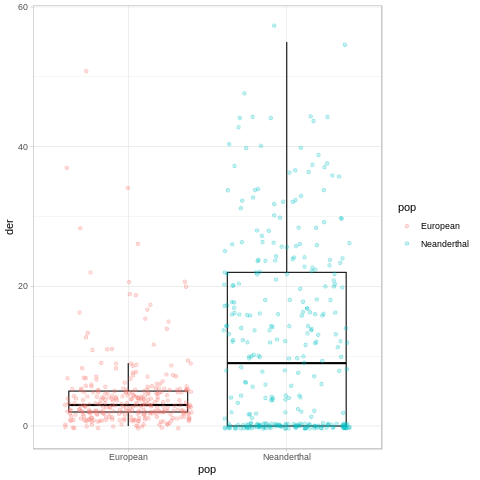

In [17]:
%%R

read.table("DAV_genomes_22_2_samples.txt", header = T) %>%
    gather("pop", "geno", 3:6) %>%
    mutate(pop = ifelse(str_detect(pop, "European"), "European", "Neanderthal")) %>%
    mutate(pos = trunc(pos/100000)) %>%
    group_by(pos, pop) %>%
    summarize(der = sum(geno)) %>%
    ungroup() %>%
    ggplot(aes(x = pop, y = der)) +
    geom_boxplot(color = "black", alpha = 0) +
    geom_jitter(aes(color = pop), alpha = 0.25) +
    theme_light()


[<img src="arrow.png" width="100" style="float: left;">](#casa) &nbsp;

&nbsp;